In [1]:
import numpy as np
import pandas as pd
import os
import h5py
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Input data files are available in the "../input/" directory

In [2]:
# Preprocessing
X, Y = [], []
img_size= (300, 300)
for root,_,files in os.walk("../input/fire-dataset/fire_dataset/fire_images"):
    for file in files:
        x = cv.imread(os.path.join(root, file))
        if(x is None):
            print(file)
            continue
        x = cv.resize(x, img_size, interpolation=cv.INTER_AREA)
        X.append(x/255.0)
        Y.append(1)
for root,_,files in os.walk("../input/fire-dataset/fire_dataset/non_fire_images"):
    for file in files:
        x = cv.imread(os.path.join(root, file))
        if(x is None):
            print(file)
            continue
        x = cv.resize(x, img_size, interpolation=cv.INTER_AREA)
        X.append(x/255.0)
        Y.append(0)
X = np.stack(X)
Y = np.asarray(Y)
num_fire_images = np.sum(Y == 1)
num_non_fire_images = np.sum(Y == 0)
print("Number of Fire Images:", num_fire_images)
print("Number of non-Fire Images:", num_non_fire_images)
X_tv, X_test, Y_tv, Y_test = train_test_split(X, Y, test_size = 0.1, shuffle=True, stratify=Y, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_tv, Y_tv, test_size=0.2, shuffle=True, stratify=Y_tv, random_state=2)
class_weights = {0:num_fire_images/X.shape[0], 1:num_non_fire_images/X.shape[0]}
print("Class Weights:",class_weights)

non_fire.189.png
Number of Fire Images: 755
Number of non-Fire Images: 243
Class Weights: {0: 0.7565130260521042, 1: 0.24348697394789579}


In [3]:
# Model building
input_tensor = keras.Input(shape=(300, 300, 3))
inception = keras.applications.InceptionV3(include_top = False, weights='imagenet',input_tensor=input_tensor)
for layer in inception.layers[:]:
    layer.trainable = False

A = keras.layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu')(inception.output)
A = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu')(A)
A = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1))(A)
A = keras.layers.Flatten()(A)
A = keras.layers.Dense(128, activation='relu')(A)
A = keras.layers.Dense(32, activation='relu')(A)
out = keras.layers.Dense(1, activation='sigmoid')(A)

model = keras.Model(inputs=input_tensor, outputs=out, name='Inception_based_model')
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(), metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "Inception_based_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________

In [4]:
# Model training
num_epoch = 10
batch_size = 64
history = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), epochs= num_epoch, batch_size= batch_size, verbose=2)
keys_list = [('loss', 'val_loss'), ('acc', 'val_acc'), ('precision', 'val_precision'), ('recall', 'val_recall')]


Epoch 1/10
12/12 - 6s - loss: 2.9230 - acc: 0.6240 - precision: 0.7725 - recall: 0.7127 - val_loss: 2.1745 - val_acc: 0.7556 - val_precision: 0.7556 - val_recall: 1.0000
Epoch 2/10
12/12 - 2s - loss: 0.7340 - acc: 0.8036 - precision: 0.8295 - recall: 0.9319 - val_loss: 0.4916 - val_acc: 0.8333 - val_precision: 0.9818 - val_recall: 0.7941
Epoch 3/10
12/12 - 2s - loss: 0.2547 - acc: 0.9150 - precision: 0.9496 - recall: 0.9374 - val_loss: 0.2939 - val_acc: 0.9000 - val_precision: 0.9758 - val_recall: 0.8897
Epoch 4/10
12/12 - 2s - loss: 0.1334 - acc: 0.9554 - precision: 0.9740 - recall: 0.9669 - val_loss: 0.2287 - val_acc: 0.9056 - val_precision: 0.9685 - val_recall: 0.9044
Epoch 5/10
12/12 - 2s - loss: 0.0830 - acc: 0.9749 - precision: 0.9907 - recall: 0.9761 - val_loss: 0.1737 - val_acc: 0.9389 - val_precision: 0.9630 - val_recall: 0.9559
Epoch 6/10
12/12 - 2s - loss: 0.0576 - acc: 0.9847 - precision: 0.9908 - recall: 0.9890 - val_loss: 0.2031 - val_acc: 0.9333 - val_precision: 0.9844 -

In [5]:
keys_list = []
ls = list(history.history.keys())
for i in range(len(ls)//2):
    keys_list.append((ls[i], 'val_'+ls[i]))

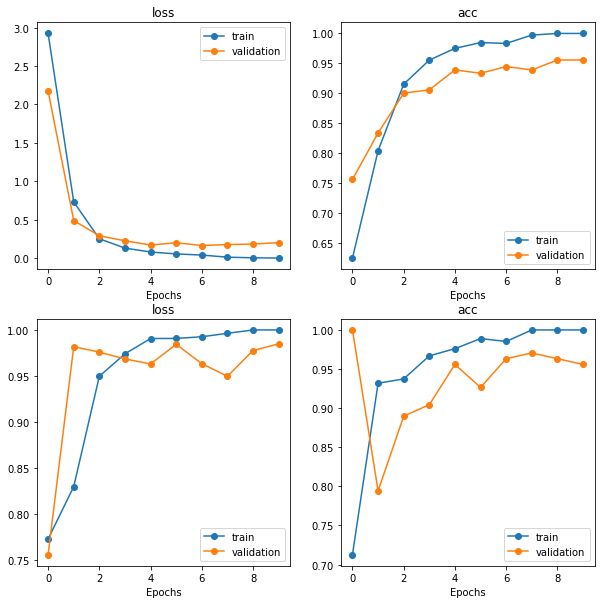

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=len(keys_list)//2, figsize=(10, 10))
for i in range(2):
    for j in range(len(keys_list)//2):
        axs[i, j].plot(range(num_epoch), history.history.get(keys_list[i*2 + j][0]), '-o')
        axs[i, j].plot(range(num_epoch), history.history.get(keys_list[i*2 + j][1]), '-o')
        axs[i, j].set_title(keys_list[i*2 + j][0])
        axs[i, j].set_xlabel('Epochs')
        axs[i, j].legend(['train', 'validation'])

In [15]:
model_json = model.to_json()
with open("Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Weights.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
# Model testing
Y_pred = (model.predict(X_test)>0.5).astype(np.int64)
acc = accuracy_score(Y_test, Y_pred)
rec = recall_score(Y_test, Y_pred)
pre = precision_score(Y_test, Y_pred)

print("Test Accuracy:",acc)
print("Test Precision:",pre)
print("Test Recall:",rec)

Test Accuracy: 0.97
Test Precision: 0.9866666666666667
Test Recall: 0.9736842105263158
